In [1]:
from datetime import datetime, timedelta
import fsspec
from itertools import groupby, repeat
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np
import os
import requests
import shutil
import warnings
import xarray as xr
import pandas as pd
from operator import itemgetter
import math

from ormhw.core import MAX_THREADS, CE04, CURATED_DIR, DATA_DIR, BoundingBox
from ormhw.core import CE01, CE02, CE04, COLUMBIA_RIVER, CAPE_BLANCO, NH_LINE
from ormhw.oisstv2 import OISSTV2
from ormhw.transitions import CBR
from ormhw.gebco import import_gebco

In [2]:
years = range(2015,2024)
figsize = (6,5)
dpi = 600
filename = 'mhws_ce04'
filetype = 'jpg'
matplotlib.rcParams.update({'font.size': 8})

In [3]:
ds = xr.open_dataset(os.path.join(CURATED_DIR, 'sst.nc'))
dsc = xr.open_dataset(os.path.join(CURATED_DIR, 'sst_clim_w11.nc'))
dsp = xr.open_dataset(os.path.join(CURATED_DIR, 'sst_90th_w11.nc'))
dsgte = xr.open_dataset(os.path.join(CURATED_DIR, 'sst_mhw_mask.nc'))
mhws = pd.read_csv(os.path.join(CURATED_DIR, 'mhws_ce04.csv'))

In [4]:
ts = ds.sel(latitude = CE04.lat, longitude = CE04.lon, method = 'nearest')
cs = dsc.sel(latitude = CE04.lat, longitude = CE04.lon, method = 'nearest')
ps = dsp.sel(latitude = CE04.lat, longitude = CE04.lon, method = 'nearest')

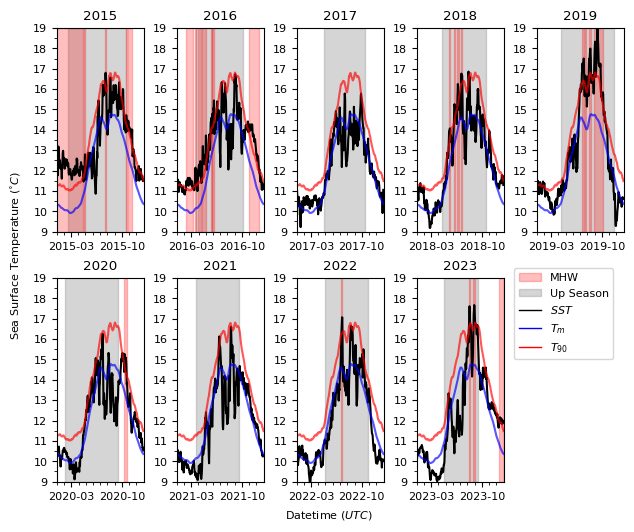

In [5]:
fig = plt.figure(figsize = figsize, constrained_layout = True)
grid = (2,5)
ax15 = plt.subplot2grid(grid, (0,0), colspan = 1,rowspan = 1)
ax16 = plt.subplot2grid(grid, (0,1), colspan = 1,rowspan = 1, sharey=ax15)
ax17 = plt.subplot2grid(grid, (0,2), colspan = 1,rowspan = 1, sharey=ax15)
ax18 = plt.subplot2grid(grid, (0,3), colspan = 1,rowspan = 1, sharey=ax15)
ax19 = plt.subplot2grid(grid, (0,4), colspan = 1,rowspan = 1, sharey=ax15)
ax20 = plt.subplot2grid(grid, (1,0), colspan = 1,rowspan = 1, sharey=ax15)
ax21 = plt.subplot2grid(grid, (1,1), colspan = 1,rowspan = 1, sharey=ax15)
ax22 = plt.subplot2grid(grid, (1,2), colspan = 1,rowspan = 1, sharey=ax15)
ax23 = plt.subplot2grid(grid, (1,3), colspan = 1, rowspan = 1, sharey=ax15)

axs = [ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22,ax23]
for year in years:
    idx = years.index(year)
    ax = axs[idx]
    
    _ds = ts.sel(time = slice(datetime(year,1,1),datetime(year,12,31,23,59,59)))
    ax.plot(_ds.time, _ds.sea_surface_temperature, color = 'black')

    _clim = cs.copy(deep = True)
    _clim['time'] = [datetime.strptime(f'{year}-{v}','%Y-%j') for v in _clim.dayofyear.values]
    ax.plot(_clim.time, _clim.sea_surface_temperature,color = 'blue', alpha = 0.66)
    
    _dsp = ps.copy(deep = True)
    _dsp['time'] = [datetime.strptime(f'{year}-{v}','%Y-%j') for v in _dsp.dayofyear.values]
    ax.plot(_dsp.time, _dsp.sea_surface_temperature,color = 'red', alpha = 0.66)

    ymhws = mhws[(pd.to_datetime(mhws.Te) <= datetime(year,12,31,23,59,59)) & (pd.to_datetime(mhws.Te) >= datetime(year,1,19))]
    for mhwidx, ymhw in ymhws.iterrows():
        if year == 2019:
            if mhwidx == ymhws.index.max():
                ax.axvspan(ymhw['Ts'], ymhw['Te'], color = 'red', zorder = 1, alpha = 0.25,label = 'MHW')

            else:
                ax.axvspan(ymhw['Ts'], ymhw['Te'], color = 'red', zorder = 1, alpha = 0.25)
        else:
            ax.axvspan(ymhw['Ts'], ymhw['Te'], color = 'red', zorder = 1, alpha = 0.25)



    ax.set_ylim(9,19)
    ax.set_xlim(datetime(year,1,1), datetime(year,12,31,23,59,59))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.5))
    ax.xaxis.set_major_locator(mdates.MonthLocator([3,10]))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))

    ax.set_title(str(year))
    

    SF = CBR[year]
    spring = datetime.strptime(f"{year}-{SF['spring']}",'%Y-%j')
    fall = datetime.strptime(f"{year}-{SF['fall']}",'%Y-%j')
    if year == 2019:
        ax.axvspan(spring,fall, color = 'gray',zorder = 0,alpha = 0.33,label = 'Up Season')
    else:
        ax.axvspan(spring,fall, color = 'gray',zorder = 0,alpha = 0.33)
    
    
fig.text(0.5, -0.02, r'Datetime ($UTC$)' , ha='center', va='center')
fig.text(-0.02, 0.5, r'Sea Surface Temperature ($^{\circ}C$)', ha='center', va='center', rotation='vertical')

ax.plot([],[],color = 'black', zorder = 2,linewidth = 1, linestyle = '-', label = '$SST$')
ax.plot([],[],color = 'blue', zorder = 2,linewidth = 1, linestyle = '-', label = r'$T_m$')
ax.plot([],[],color = 'red', zorder = 2,linewidth = 1, linestyle = '-', label = r'$T_{90}$')



fig.legend(ncol = 1, loc = (0.81,0.325))

plt.savefig(f'/home/jovyan/oregon-shelf-mhw/figures/{filename}.{filetype}', dpi = dpi, bbox_inches='tight', pad_inches=0.1)

In [6]:
ds_ce04 = ds.sel(latitude = CE04.lat, longitude = CE04.lon, method = 'nearest')
dsc_ce04 = dsc.sel(latitude = CE04.lat, longitude = CE04.lon, method = 'nearest')
dsp_ce04 = dsp.sel(latitude = CE04.lat, longitude = CE04.lon, method = 'nearest')

In [7]:
mhws = mhws[[c for c in mhws.columns if 'Unnamed' not in c]]
mhws['Ts'] = pd.to_datetime(mhws.Ts)
mhws['Te'] = pd.to_datetime(mhws.Te)
mhws = mhws[(mhws.Te >= datetime(2015,1,1)) & (mhws.Ts<= datetime(2023,12,31,23,59,59))]
mhws = mhws.reset_index(drop = True)

In [8]:
blobtracker = pd.read_csv(os.path.join(os.path.join(DATA_DIR, 'blobtracker'),'blobtracker.csv'))
blobtracker.index = pd.to_datetime(blobtracker.time)
blobtracker.index = blobtracker.index.tz_localize(None)
blobtracker = blobtracker[(blobtracker.index > '2013-01-01') & (blobtracker.index <= '2024-01-01')]
blob_list = []
for start_time, blob_event in blobtracker.iterrows():
    blob_start = start_time
    blob_end = start_time + timedelta(blob_event.duration)
    blob_dist = blob_event.min_dist_to_coast
    for _, mhw in mhws.iterrows():
        if blob_start <= mhw.Ts <= mhw.Te <= blob_end:
            row = blob_event.to_frame().T
            row['matching'] = mhw.Ts
            blob_list.append(row)
blob_matches = pd.concat(blob_list)
blob_matches = blob_matches.reset_index()


matching_list = []
for mhwidx, mhw in mhws.iterrows():
#     # Exclude MHWs that did not occur or overlap with the upwelling season.
#     year = mhw.Ts.year
#     SF = CBR[year]
#     spring = datetime.strptime(f"{year}-{SF['spring']}",'%Y-%j')
#     fall = datetime.strptime(f"{year}-{SF['fall']}",'%Y-%j')
#     if mhw.Te < spring and mhw.Ts > fall:
#         continue
    
    blob_match = blob_matches[blob_matches.matching == mhw.Ts]
    if len(blob_match) == 0:
        d = pd.DataFrame({'Ts_CE04':[pd.to_datetime(mhw.Ts).strftime('%Y-%m-%d')],'feature_name': [None]})
        matching_list.append(d)
    elif len(blob_match) == 1:
        
        if blob_match.feature_name.values == '':
            feature = blob_match.blob_id.values
        else:
            feature = blob_match.feature_name.values

        d = pd.DataFrame({'Ts_CE04':blob_match.matching.values,'feature_name': feature})
        matching_list.append(d)
    else:
        best = blob_match[blob_match.min_dist_to_coast == blob_match.min_dist_to_coast.min()]
        
        if best.feature_name.values == '':
            feature = best.blob_id.values
        else:
            feature = best.feature_name.values
        
        d = pd.DataFrame({'Ts_CE04':best.matching.values,'feature_name': best.feature_name.values})
        matching_list.append(d)
my_matches = pd.concat(matching_list)
my_matches = my_matches.reset_index(drop = True)

In [9]:
print('$Ts$', '&','$Te$','&','$D$','&',r'$i_{max}$','&',r'$i_{mean}$','&',r'$i_{var}$','&','$Category$', '&','$Blob\\ ID$','\\\\','\hline')

avgs = {}

for idx, mhw in mhws.iterrows():
    
    # Exclude MHWs that did not occur or overlap with the upwelling season.
    year = mhw.Te.year
    SF = CBR[year]
    spring = datetime.strptime(f"{year}-{SF['spring']}",'%Y-%j')
    fall = datetime.strptime(f"{year}-{SF['fall']}",'%Y-%j')
    
    if not spring <= mhw.Ts <= fall and not spring <= mhw.Te <= fall and not mhw.Ts <= spring <= mhw.Te and not mhw.Ts <= fall <= mhw.Te:
        continue
    

    # Derive basic stats for each MHW.
    _ds = ds_ce04.sel(time = slice(mhw.Ts, mhw.Te))
    _ds['dayofyear'] = _ds['time.dayofyear']
    _clim = dsc_ce04.sel(dayofyear = _ds.dayofyear)
    _dsp = dsp_ce04.sel(dayofyear = _ds.dayofyear)
    imax = np.round(np.max(_ds.sea_surface_temperature - _clim.sea_surface_temperature),2).values
    imean = np.round(np.mean(_ds.sea_surface_temperature - _clim.sea_surface_temperature),2).values
    Tmax = np.float64(_ds.sea_surface_temperature.max())
    Ts = np.float64(_ds.sea_surface_temperature[_ds.dayofyear == _ds.dayofyear.min()])
    Cs = np.float64(_clim.sea_surface_temperature[_clim.dayofyear == _clim.dayofyear.min()])
    Te = np.float64(_ds.sea_surface_temperature[_ds.dayofyear == _ds.dayofyear.max()])
    Ce = np.float64(_clim.sea_surface_temperature[_clim.dayofyear == _clim.dayofyear.max()])
    ivar = np.round(np.std(_ds.sea_surface_temperature),2).values

    cat_delim = _dsp.sea_surface_temperature.values -_clim.sea_surface_temperature.values
    cat_max = np.nanmax(imax/cat_delim)
    if  1<=cat_max<2:
        category = 'moderate'
    elif 2<= cat_max <3:
        category = 'strong'
    elif 3<= cat_max < 4:
        category = 'severe'
    elif 4<= cat_max:
        category = 'extreme'
    
    
    #Determine Blobtracker match.
    blobtracker_match = my_matches[my_matches.Ts_CE04 == mhw.Ts]
    if len(blobtracker_match) == 0:
        blob_id = 'None'
    else:
        blob_id = blobtracker_match.feature_name.values[0]
    
    # Print in LaTeX table format.
    col1 = mhw.Ts.strftime('%Y-%m-%d')
    col2 = mhw.Te.strftime('%Y-%m-%d')
    col3 = str(mhw.D)#.zfill(3)
    col4 = str(imax).ljust(4,'0')
    col5 = str(imean).ljust(4,'0')
    col6 = str(ivar).ljust(4,'0')
    col7 = category
    col8 = blob_id

    avgs[mhw.Te] = imean
    
    print(col1, '&',col2, '&', col3, '&', col4,'&', col5,'&', col6,'&', col7,'&', col8,'\\\\')

<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_737/3248203311.py:1: SyntaxWarning: invalid escape sequence '\h'
  print('$Ts$', '&','$Te$','&','$D$','&',r'$i_{max}$','&',r'$i_{mean}$','&',r'$i_{var}$','&','$Category$', '&','$Blob\\ ID$','\\\\','\hline')


$Ts$ & $Te$ & $D$ & $i_{max}$ & $i_{mean}$ & $i_{var}$ & $Category$ & $Blob\ ID$ \\ \hline
2014-11-27 & 2015-04-21 & 146 & 2.87 & 2.04 & 0.48 & severe & NEP2013d \\
2015-04-24 & 2015-05-01 & 8 & 1.70 & 1.13 & 0.38 & strong & NEP2013d \\
2015-07-23 & 2015-07-28 & 6 & 2.69 & 2.40 & 0.24 & moderate & NEP2013d \\
2015-10-20 & 2015-10-24 & 5 & 1.58 & 1.42 & 0.16 & moderate & NEP2013d \\
2016-03-29 & 2016-04-12 & 15 & 2.12 & 1.68 & 0.29 & strong & NEP2016a \\
2016-04-17 & 2016-05-04 & 18 & 2.47 & 1.79 & 0.41 & severe & NEP2016a \\
2016-05-22 & 2016-05-26 & 5 & 1.82 & 1.72 & 0.13 & moderate & NEP2016a \\
2016-05-29 & 2016-06-06 & 9 & 2.21 & 1.73 & 0.32 & moderate & NEP2016a \\
2018-05-15 & 2018-05-21 & 7 & 1.73 & 1.62 & 0.15 & moderate & None \\
2018-06-06 & 2018-06-12 & 7 & 1.94 & 1.67 & 0.20 & moderate & None \\
2018-06-20 & 2018-06-25 & 6 & 2.19 & 1.81 & 0.26 & moderate & None \\
2018-07-07 & 2018-07-11 & 5 & 2.16 & 1.97 & 0.16 & moderate & nan \\
2019-07-09 & 2019-07-19 & 11 & 3.12 & 2.61

In [10]:
years = range(2015,2024)
figsize = (6,5)
dpi = 600
filename = 'mhw_presence'
filetype = 'jpg'
matplotlib.rcParams.update({'font.size': 8})

In [11]:
mhw_stats = xr.open_dataset(os.path.join(CURATED_DIR,'mhw_spatial_stats.nc'))
stat_cmap = matplotlib.colormaps.get_cmap('Reds')
stat_cmap.set_under('white')

In [12]:
bbox = BoundingBox(lat_min = 41, lat_max = 47, lon_min = -126.75, lon_max = -123.75)
gebco_filepath = '/home/jovyan/data/gebco/GEBCO_2023.nc'
gebco = import_gebco(gebco_filepath,bounding_box = bbox)
gebco_land = gebco.where(gebco.depth <=0, drop = True)
landx, landy = np.meshgrid(gebco_land.lon, gebco_land.lat)
landz = gebco_land.depth

seax, seay = np.meshgrid(gebco.lon, gebco.lat)
seaz = gebco.depth

gebco_cmap = matplotlib.colormaps.get_cmap('Grays')
gebco_cmap.set_under('gray')

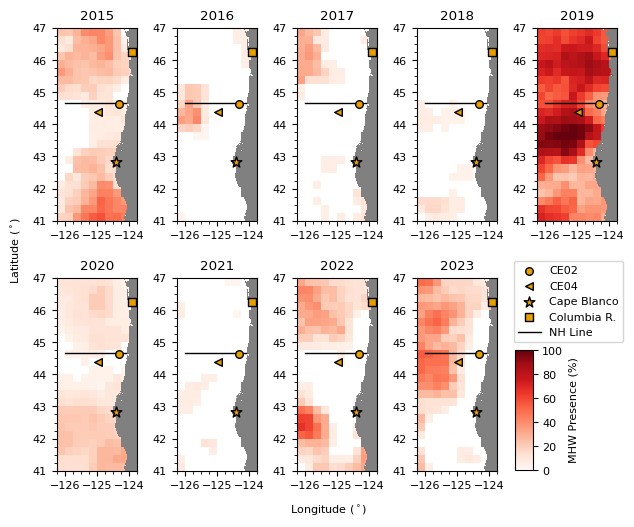

In [13]:
fig = plt.figure(figsize = figsize, constrained_layout = True)
grid = (2,5)
ax15 = plt.subplot2grid(grid, (0,0), colspan = 1,rowspan = 1)
ax16 = plt.subplot2grid(grid, (0,1), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax17 = plt.subplot2grid(grid, (0,2), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax18 = plt.subplot2grid(grid, (0,3), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax19 = plt.subplot2grid(grid, (0,4), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax20 = plt.subplot2grid(grid, (1,0), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax21 = plt.subplot2grid(grid, (1,1), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax22 = plt.subplot2grid(grid, (1,2), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax23 = plt.subplot2grid(grid, (1,3), colspan = 1, rowspan = 1, sharex=ax15, sharey=ax15)

axs = [ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22,ax23]

for year in years:
    idx = years.index(year)
    ax = axs[idx]
    ax.set_facecolor('gray')
    
    ystat = mhw_stats.sel(year = year)
    staty, statx = np.meshgrid(ystat.latitude, ystat.longitude)
    statz = ystat.ratio * 100
    statp = ax.pcolormesh(statx, staty, statz, cmap = stat_cmap, vmin = 1, vmax = 100)
    

    ax.set_ylim(41,47)
    ax.set_xlim(-126.25,-123.75)
    ax.set_box_aspect((47-41)/(-123.75 + 126.25))
    ax.set_title(year)
    ax.pcolormesh(landx, landy, landz, cmap = gebco_cmap, zorder = 1, vmin = 0, vmax = 0.0001)

    ax.scatter(CE02.lon, CE02.lat, s = 30, color = (230/255,159/255,0/255), marker = 'o',edgecolors = 'black', zorder = 3, linewidth = 1)
    ax.scatter(CE04.lon, CE04.lat, s = 30, color = (230/255,159/255,0/255), marker = '<',edgecolors = 'black', zorder = 3 ,linewidth = 1)
    ax.scatter(CAPE_BLANCO.lon, CAPE_BLANCO.lat, s = 65, color = (230/255,159/255,0/255), marker = '*',edgecolors = 'black', zorder = 3,linewidth = 1)
    ax.scatter(COLUMBIA_RIVER.lon, COLUMBIA_RIVER.lat, s = 35, color = (230/255,159/255,0/255), marker = 's',edgecolors = 'black', zorder = 3,linewidth = 1)
    ax.plot([NH_LINE.lon_min,NH_LINE.lon_max],[NH_LINE.lat,NH_LINE.lat],color = 'black', zorder = 2,linewidth = 1, linestyle = '-')


    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.25))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))
    

    
fig.text(0.5, -0.02, r'Longitude ($^\circ$)' , ha='center', va='center')
fig.text(-0.02, 0.5, r'Latitude ($^\circ$)', ha='center', va='center', rotation='vertical')

ax.scatter([],[], s = 30, color = (230/255,159/255,0/255), marker = 'o',edgecolors = 'black', zorder = 3, linewidth = 1, label = 'CE02')
ax.scatter([],[], s = 30, color = (230/255,159/255,0/255), marker = '<',edgecolors = 'black', zorder = 3 ,linewidth = 1, label = 'CE04')
ax.scatter([],[], s = 65, color = (230/255,159/255,0/255), marker = '*',edgecolors = 'black', zorder = 3,linewidth = 1, label = 'Cape Blanco')
ax.scatter([],[], s = 35, color = (230/255,159/255,0/255), marker = 's',edgecolors = 'black', zorder = 3,linewidth = 1,label = 'Columbia R.')
ax.plot([],[],color = 'black', zorder = 2,linewidth = 1, linestyle = '-', label = 'NH Line')
    

fig.legend( ncol = 1, loc = (0.81,0.35))
cbar_ax = fig.add_axes([0.81, 0.06, 0.03, 0.24])
cbar = fig.colorbar(statp, cax=cbar_ax,label = r'MHW Presence (%)') 
cbar.set_ticks([0,20,40,60,80,100])

plt.savefig(f'/home/jovyan/oregon-shelf-mhw/figures/{filename}.{filetype}', dpi = dpi,bbox_inches='tight', pad_inches=0.1)